In [1]:
import os
import sys
import time
from datetime import date
from datetime import datetime
import time
import json
import platform

import stoneburner
#//*** Custom Functions:
#//*** mr_clean_text(input_series)
#//*** tokenize_series(input_series)
#//*** remove_stop_words(input_series)

# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
subreddits = ["wallstreetbets", "stocks", "wallstreetbetsOGs", "spacs", "investing", "pennystocks", "stockmarket", "options", "robinhoodpennystocks", "wallstreetbetsnew", "smallstreetbets"]
filepath = "./data/"
filename_suffix = "_comments.csv.zip"
#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [2]:
#//*** Input_filename: Comments to Process.
#//*** This will eventually be a list of files
#input_filename  =".\\data\\wallstreetbets_comments.csv.zip"
interval="daily"

#//*** Path to processed files
#output_filename = f"./data/processed_reddit_v4_{interval}.csv.zip"
output_filename = f"./ignore_folder/training_amc_{interval}.csv"

#//*** Path to the stock ticker JSON file
stock_ticker_filename = "./data/stock_tickers.json"

#//*** Convert Path to Mac formatting if needed
#if platform.system() == 'Darwin':
#    output_filename = output_filename.replace("\\","/")
#    stock_ticker_filename = stock_ticker_filename.replace("\\","/")

#//*** Load the Stock Tickers
f = open(stock_ticker_filename, "r")
symbols = json.loads(f.read())['symbols']

symbols = ["amc"]
f.close()

process_tfidf = False

print(symbols)
#//*** Convert symbols to lower case
symbols = [x.lower() for x in symbols]



raw_df = pd.DataFrame()

start_time = time.time()

#//*** Load each Subreddit for Aggregation
for subreddit in subreddits:
    #//*** Filepath + subreddit name + csv.zip
    input_filename = filepath+subreddit+filename_suffix

    #//*** Convert Path to Mac formatting if needed
    #if platform.system() == 'Darwin':
    #    input_filename = input_filename.replace("\\","/")
   
    print(f"Reading Compressed CSV: {input_filename}")
    
    #//*** Read Each DataFrame and combine with raw_df
    raw_df = pd.concat([raw_df,pd.read_csv(input_filename,compression='zip' )])

#//*** Reset the index, since multiple indexes have been combined
raw_df.reset_index(drop=True, inplace=True)

print(f"Files Loaded: {round(time.time()-start_time,2)}s")
print(f"Total Records: {len(raw_df)}")
    

['amc']
Reading Compressed CSV: ./data/wallstreetbets_comments.csv.zip
Reading Compressed CSV: ./data/stocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsOGs_comments.csv.zip
Reading Compressed CSV: ./data/spacs_comments.csv.zip
Reading Compressed CSV: ./data/investing_comments.csv.zip
Reading Compressed CSV: ./data/pennystocks_comments.csv.zip
Reading Compressed CSV: ./data/stockmarket_comments.csv.zip
Reading Compressed CSV: ./data/options_comments.csv.zip
Reading Compressed CSV: ./data/robinhoodpennystocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsnew_comments.csv.zip
Reading Compressed CSV: ./data/smallstreetbets_comments.csv.zip
Files Loaded: 50.92s
Total Records: 4432533


In [4]:
raw_df['body'] = raw_df['body'].astype('str')

#//*** Convert UTC to date (not datetime)
#//** Second pass goes from 12-21 to 4-19
try:
    raw_df['created_utc'] = raw_df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
except:
    print()
    
#//*** Keep just date and body fields
raw_df = raw_df[['created_utc','body']]
raw_df

,created_utc,body
0,2012-04-11 09:46:43,This is a fantastic idea! I'll toss mine up in...
1,2012-04-11 10:39:08,INTC is on 4/17
2,2012-04-11 11:02:31,"straddle, call, straddle, put, put, put, strad..."
3,2012-04-11 11:47:11,"GMCR falls, GOOG falls *slightly*, GRPN will g..."
4,2012-04-11 12:44:33,CROX 4/26\n\nBZH 5/1\n\ni'm expecting both to ...
...,...,...
4432528,2021-06-30 18:34:33,"Jun 30, 9.30pm EST.\n\n \nI just saw this pos..."
4432529,2021-06-30 19:08:36,Good run through. The mill is running and we’r...
4432530,2021-06-30 20:11:10,Back to normal not there yet
4432531,2021-06-30 20:16:51,💎👐🚀🚀🚀🚀


In [4]:
raw_df

,created_utc,body
0,2012-04-11 09:46:43,This is a fantastic idea! I'll toss mine up in...
1,2012-04-11 10:39:08,INTC is on 4/17
2,2012-04-11 11:02:31,"straddle, call, straddle, put, put, put, strad..."
3,2012-04-11 11:47:11,"GMCR falls, GOOG falls *slightly*, GRPN will g..."
4,2012-04-11 12:44:33,CROX 4/26\n\nBZH 5/1\n\ni'm expecting both to ...
...,...,...
4432528,2021-06-30 18:34:33,"Jun 30, 9.30pm EST.\n\n \nI just saw this pos..."
4432529,2021-06-30 19:08:36,Good run through. The mill is running and we’r...
4432530,2021-06-30 20:11:10,Back to normal not there yet
4432531,2021-06-30 20:16:51,💎👐🚀🚀🚀🚀


In [54]:
symbols = ["bb"]
interval="daily"
for symbol in symbols:
    stock_df = pd.read_csv(f"./stocks/{symbol}_{interval}.csv.zip")
    stock_df
    
    if 'date' in stock_df.columns:
        stock_df['date'] = pd.to_datetime(stock_df['date'])
        stock_df = stock_df.rename(columns={'date':'time'})
    else:
        stock_df['time'] = pd.to_datetime(stock_df['time'])
    
    #//*** Keeping this cool chunk of code as a reference
    #stock_df['time'] = stock_df['time'].apply(lambda x: x.timestamp())
    
    #//*** Remove Comments older than the first stock price
    raw_df = raw_df[ raw_df['created_utc'] >= stock_df['time'].min() ]
    
    #//*** Remove Stock Prices older than the first Comments price
    stock_df = stock_df[ stock_df['time'] >= raw_df['created_utc'].min() ]
    
    #//*** Remove Stock Prices older than the last Comments
    stock_df = stock_df[ stock_df['time'] <= raw_df['created_utc'].max() ]
    
    #//*** Reorder Comments by date
    raw_df.sort_values('created_utc',inplace=True,ignore_index=True)
    
    #//*** Reorder Stocks by date
    stock_df.sort_values('time',inplace=True, ignore_index=True)
stock_df

,time,symbol,open,high,low,close,volume
0,2014-04-11,bb,7.580,7.6800,7.23,7.28,17207547
1,2014-04-14,bb,7.400,7.4000,7.01,7.14,17803478
2,2014-04-15,bb,7.100,7.2800,7.05,7.21,10676414
3,2014-04-16,bb,7.345,7.3700,7.10,7.15,8327127
4,2014-04-17,bb,7.180,7.2700,7.12,7.15,7249876
...,...,...,...,...,...,...,...
1813,2021-06-24,bb,13.230,13.3300,12.64,12.68,22158951
1814,2021-06-25,bb,12.210,12.4600,11.76,12.12,36954177
1815,2021-06-28,bb,12.060,12.8600,12.04,12.80,31117766
1816,2021-06-29,bb,12.530,12.6905,12.19,12.24,14336758


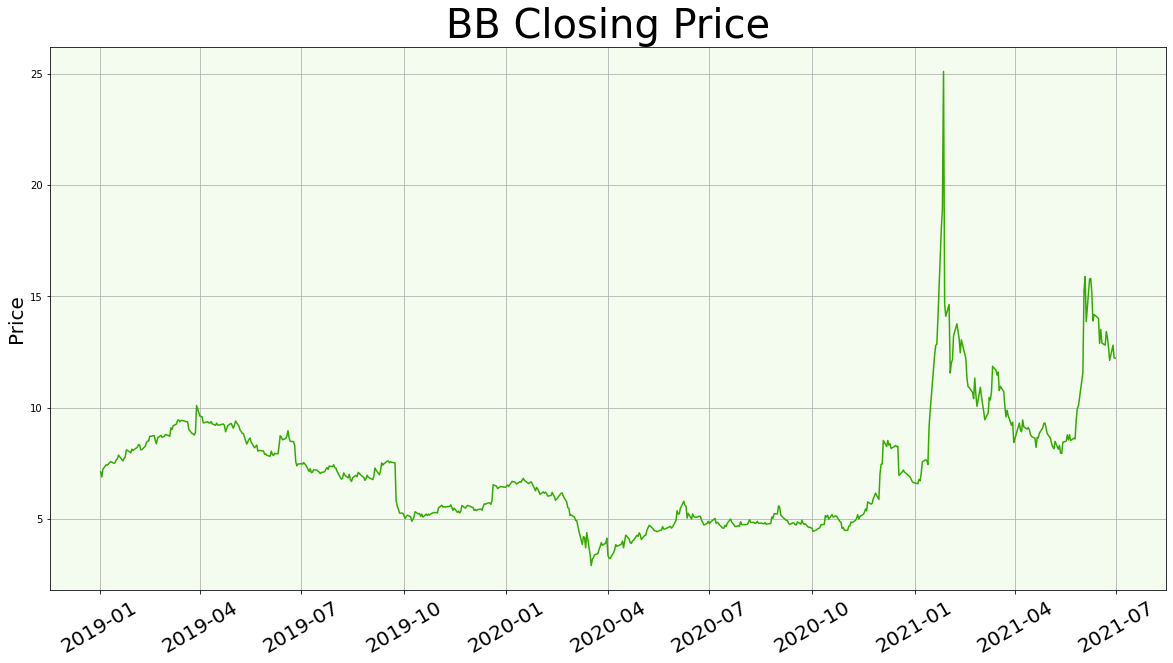

In [58]:
tdf = stock_df[stock_df['time'] >= pd.to_datetime("2019-01-01")]

plt.rcParams['figure.figsize'] = [20,10]
fig,ax = plt.subplots()
displaysize=40
ax.plot(tdf['time'],tdf['close'],color='#34aa01' )
ax.set_facecolor("#f3fcef")
plt.title("BB Closing Price",fontsize=displaysize)
plt.xticks( fontsize=displaysize/2,rotation=30)
plt.ylabel("Price",fontsize=displaysize/2)
plt.grid()
    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

plt.rcParams['figure.figsize'] = [10,5]

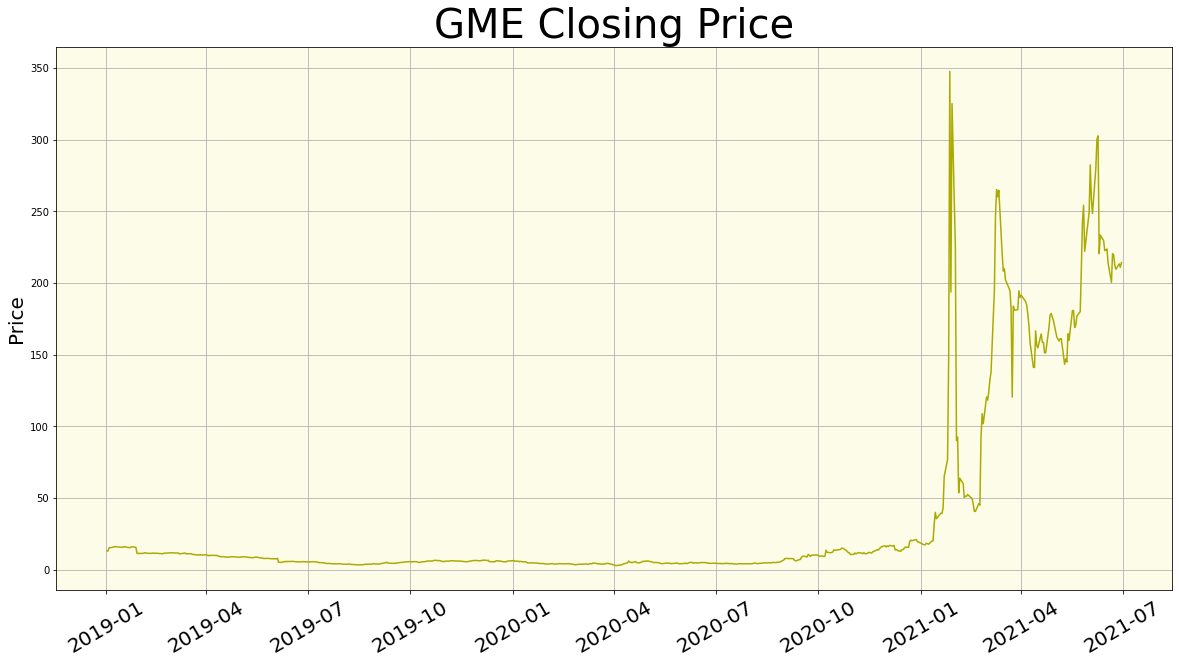

In [51]:
tdf = stock_df[stock_df['time'] >= pd.to_datetime("2019-01-01")]

plt.rcParams['figure.figsize'] = [20,10]
fig,ax = plt.subplots()
displaysize=40
ax.plot(tdf['time'],tdf['close'],color='#aaaa01' )
ax.set_facecolor("#fcfce8")
plt.title("GME Closing Price",fontsize=displaysize)
plt.xticks( fontsize=displaysize/2,rotation=30)
plt.ylabel("Price",fontsize=displaysize/2)
plt.grid()
    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

plt.rcParams['figure.figsize'] = [10,5]

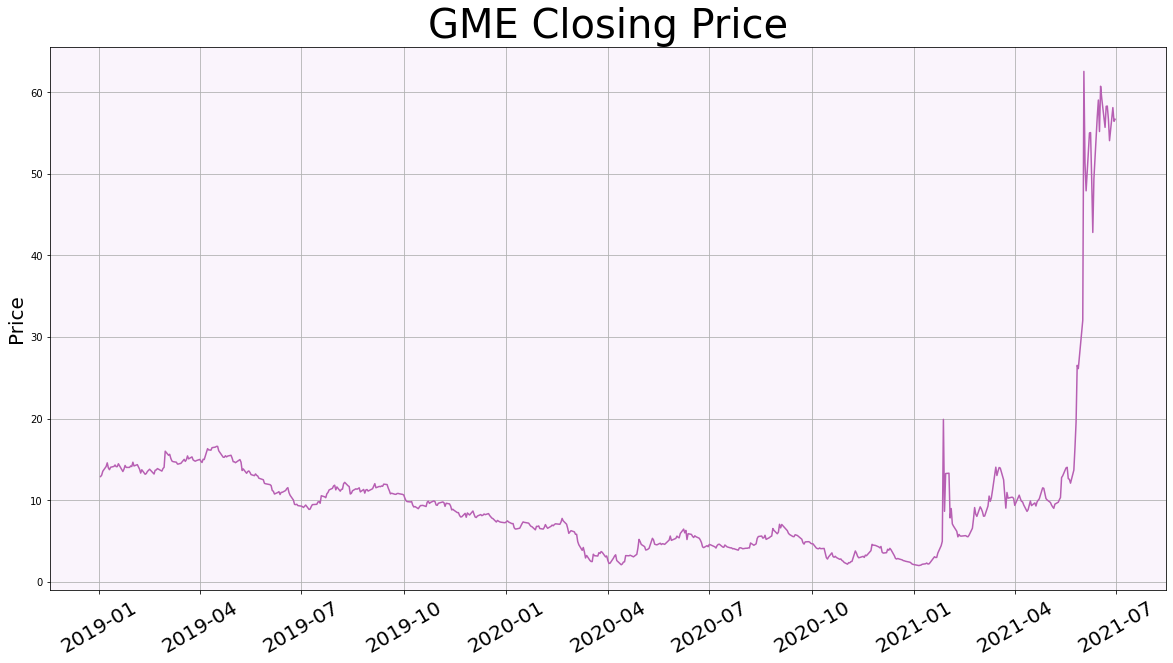

In [42]:
tdf = stock_df[stock_df['time'] >= pd.to_datetime("2019-01-01")]

plt.rcParams['figure.figsize'] = [20,10]
fig,ax = plt.subplots()
displaysize=40
ax.plot(tdf['time'],tdf['close'],color='#b75fb3' )
ax.set_facecolor("#faf4fc")
plt.title("GME Closing Price",fontsize=displaysize)
plt.xticks( fontsize=displaysize/2,rotation=30)
plt.ylabel("Price",fontsize=displaysize/2)
plt.grid()
    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

plt.rcParams['figure.figsize'] = [10,5]

In [60]:
#//*** Group the stock values by time, this is essentially like itterrows()
groups = stock_df.groupby('time')


In [61]:
cdf = raw_df.copy()

#https://www.geeksforgeeks.org/how-to-iterate-over-dataframe-groups-in-python-pandas/
key_list = list(groups.groups.keys())

bin_df = pd.DataFrame()

start_time = time.time()
comment_min_time = raw_df['created_utc'].min()
comment_max_time = raw_df['created_utc'].max()
min_index = 0
start_time = time.time()
print("Processing...")
for x in range(len(key_list)-1):
    
    #//*** Get a single line of stocks as a dataframe
    loop_stocks_df = groups.get_group((key_list)[x]).copy()  
    
    t1 = groups.get_group((key_list)[x])['time'].iloc[0]
    t2 = groups.get_group((key_list)[x+1])['time'].iloc[0]
    
    #search through cdf to find comments that are between t1 and t2
    #if len(cdf[ (cdf['created_utc'] > t1) & (cdf['created_utc'] < t2) ]) > 0:
    #temp_df = cdf.iloc[min_index:]
    temp_df = cdf[(cdf['created_utc'] >= t1) & (cdf['created_utc'] < t2) ]
    
    if len(temp_df) == 0:
            #//*** No COmments on this Date
            loop_stocks_df['body'] = " "
            loop_stocks_df['comment_count'] = 0
    else:
        #print(temp_df.index[0])
        #print(temp_df.index[-1])
        #print(cdf.iloc[temp_df.index[0]:temp_df.index[-1]])
        temp_df = cdf.iloc[temp_df.index[0]:temp_df.index[-1]]
        #//*** Get all the body comments and combine them
        loop_stocks_df['body'] = " ".join(list(temp_df['body']))

        #//*** Get a comment count, BC IDK Y
        loop_stocks_df['comment_count'] = len(temp_df['body']) 
    
    #//*** Secret to speeding up algorithm. Get the Index value of the last item found -1. 
    #//*** When Searching above, start the search from this index. Seems to speed things up. Since we're skipping past elements that we've already found
    if len(temp_df) > 0: 
        min_index = temp_df.index[-1]

        
    
    #//*** Add the single line of loop_stocks_df to bin_df    
    bin_df = pd.concat([bin_df,loop_stocks_df])
        #print(loop_df.index)
        #print(loop_df)
        #cdf = cdf.drop(index=loop_df.index)
    
        
    
    #lengroup
   
    #if x > 1000:
    #    bin_df.head(20)
    #    print("break")
    #    break
print(f"Elapsed {round(time.time()-start_time,2)}")

#print("Merging")
#bin_df = pd.merge(bin_df,stock_df,left_on='bin_time',right_on='time')

#del bin_df['bin_time']
#print(bin_df)
print("Pickling")

#bin_df.to_pickle(output_filename,compression='zip')
print("Done!")

Processing...
Elapsed 72.54
Pickling
Done!


In [69]:
tdf = bin_df[bin_df['time'] >= pd.to_datetime("2020-01-01")]
tdf



,time,symbol,open,high,low,close,volume,body,comment_count
1441,2020-01-02,bb,6.52,6.5600,6.45,6.52,5348948,Look at you tryna get free stocks lol smart Co...,1672
1442,2020-01-03,bb,6.39,6.5500,6.39,6.46,3658228,Fake news... they don’t wanna be held for insi...,2282
1443,2020-01-06,bb,6.40,6.7400,6.40,6.68,7882607,you act like the iPhone you’re holding isn’t m...,1851
1444,2020-01-07,bb,6.76,6.8300,6.60,6.66,6363838,"But you see, it’s a cutting edge firm out of t...",1279
1445,2020-01-08,bb,6.64,6.7000,6.58,6.66,4983760,Hmm that's why I asked my question. I don't g...,956
...,...,...,...,...,...,...,...,...,...
1812,2021-06-23,bb,13.26,13.4700,12.91,13.14,22997587,Meme meta is basically selling overpriced opti...,11530
1813,2021-06-24,bb,13.23,13.3300,12.64,12.68,22158951,Your time horizon is way too short for anythin...,12330
1814,2021-06-25,bb,12.21,12.4600,11.76,12.12,36954177,TLDR: SRNE receives approval to import covid-1...,27059
1815,2021-06-28,bb,12.06,12.8600,12.04,12.80,31117766,"Me too, hate myself for buying a shit load of ...",10926


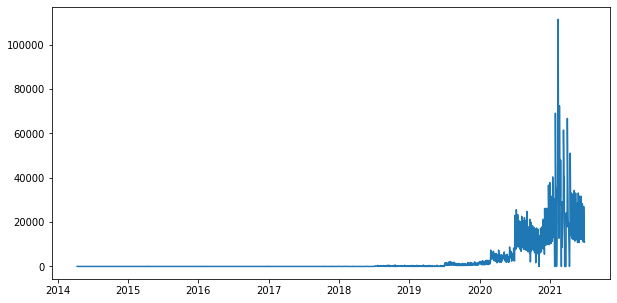

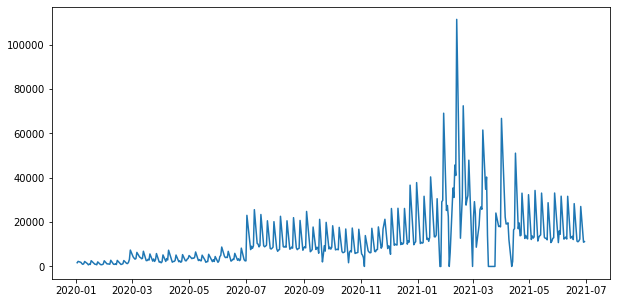

In [70]:
fig,ax = plt.subplots()

ax.plot(bin_df['time'],bin_df['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

fig,ax = plt.subplots()

ax.plot(tdf['time'],tdf['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()



In [75]:
#//***Aggreate Comments for Training
#//*** Build tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

#loop_list.append(tfidf.fit_transform(input_df['tfidf']))
tfidf_matrix = []
tfidf_list = []
tfidf = TfidfVectorizer()

print("Starting tfidf....")
start_time = time.time()
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(tdf['body'])


print(f"Built: {round(time.time()-start_time,2)}")

print(tfidf_matrix)
print

Starting tfidf....
Built: 88.67
  (0, 281443)	0.00030611349672286635
  (0, 245381)	0.0017126839108236192
  (0, 105159)	0.0003542084655873561
  (0, 181969)	0.0005910496805570602
  (0, 208781)	0.0015224092873656852
  (0, 94623)	0.0003291090212008266
  (0, 283055)	0.0003883721639328727
  (0, 385303)	0.00041376496788701213
  (0, 409283)	0.00029727059209234415
  (0, 23865)	0.0003195067995828591
  (0, 399648)	0.0007570547663323831
  (0, 155983)	0.00029965418092375173
  (0, 385284)	0.00033178717176708775
  (0, 377319)	0.00039619981359425427
  (0, 332670)	0.0007328177167562861
  (0, 138997)	0.0003754517436285288
  (0, 305130)	0.0005256737980703497
  (0, 249414)	0.0003692126510708042
  (0, 413048)	0.0006616902394883023
  (0, 135149)	0.0003127284735727467
  (0, 172151)	0.0005980587827519876
  (0, 151595)	0.0004054278507862134
  (0, 362365)	0.0007141364792686097
  (0, 283034)	0.0005758759357493903
  (0, 319574)	0.00030611349672286635
  :	:
  (375, 453906)	0.054935103307289616
  (375, 95065)	0.049

<function print>

In [74]:
#//*** Build TruncatedSVD

#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import TruncatedSVD

start_time = time.time()
print(f"Begin Truncated SVD ")

start_time=time.time()
#//*** Set the number of components to 6000. This is generating 98% variance capture
#//*** 60min data set took around 25minutes to build
tsvd = TruncatedSVD(250)
tsvd_df = pd.DataFrame(tsvd.fit_transform(tfidf_matrix))
print(tsvd.explained_variance_ratio_.sum())

print (f"Truncated SVD Done: {round(time.time()-start_time,2)}s")
#output_filename = './ignore_folder/tsvd_model_ready_daily.csv.zip'
#//*** Write Truncated SVD to disk
#tsvd_df.to_csv(output_filename, compression='zip', index=False)

Begin Truncated SVD 


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [23]:

tdf

,close,volume,open,high,low,comment_count,time
0,7.46,4545935,7.30,7.56,7.230,1672,2020-01-02
1,7.32,2217959,7.45,7.60,7.305,2282,2020-01-03
2,7.12,2903381,7.25,7.30,7.110,1851,2020-01-06
3,7.13,3206587,7.11,7.20,7.000,1279,2020-01-07
4,6.62,6556979,7.11,7.15,6.610,956,2020-01-08
...,...,...,...,...,...,...,...
371,58.30,116291804,57.04,61.10,56.800,11530,2021-06-23
372,56.70,80351219,57.98,58.76,55.660,12330,2021-06-24
373,54.06,77596927,55.75,56.29,52.970,27059,2021-06-25
374,58.11,99310240,55.10,59.36,54.330,10926,2021-06-28


In [73]:

offset_target = 1
tdf.reset_index(drop=True, inplace=True)
#/***Reorder and drop tdf columns



start_time = time.time()
print(f"Begin Concat")
#df = pd.concat([tdf,pd.DataFrame(tfidf_matrix.toarray())],axis=1)
df = pd.concat([tdf[['close','volume','open','high','low','comment_count','time']],tsvd_df],axis=1)
print (f"Concat Done: {round(time.time()-start_time,2)}s")
#del df['body']
#del df['symbol']
#start_time = time.time()
#print(f"Writing to csv")
#output_filename = f"./ignore_folder/training_amc_{interval}.csv.zip"
#tdf.to_csv(output_filename,index=False)
#print (f"Written: {round(time.time()-start_time,2)}s")





print("Building Target Offset Columns...")
#//*** Build the target variables and intervals of stock prices. This is a single value determined by target)offset

#//*** create a list of nan values of x length
nan_list = list(np.empty( offset_target )* np.nan )

#//*** Create target variable Price which is stocks + x columns in advance
#//*** Takes the closing price starting at x and gets the remainder, this generates the offset
#//*** nan_list fills the missing x values with nans
target = list(df['close'][offset_target:]) + nan_list 
target = target[:offset_target*-1]
print(len(target))
df = df[:offset_target*-1]
target = target - df['close']
print(df.shape)

print(f"Building Time Series")
#//*** Peel off Time. Used for graphing
time_series = df['time']
print(len(time_series))
del df['time']
t_cols = df.columns[:10]
df[t_cols]

Begin Concat


NameError: name 'tsvd_df' is not defined

In [51]:
tst = pd.DataFrame()
tst['close'] = tdf['close'][:-1]
tst['target'] = target

#tst['diff'] = tst['target']- tst['close']
tst
df.columns

Index([        'close',        'volume',          'open',          'high',
                 'low', 'comment_count',               0,               1,
                     2,               3,
       ...
                   240,             241,             242,             243,
                   244,             245,             246,             247,
                   248,             249],
      dtype='object', length=256)

In [25]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from keras.models import Sequential

#//*** Verify Plaid ML is working
#import plaidml.keras

import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

#plaidml.keras.install_backend()


import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

import tensorflow.keras.backend as K

K

<module 'tensorflow.keras.backend' from 'C:\\Users\\stonk013\\Anaconda3\\envs\\keras_env\\lib\\site-packages\\tensorflow\\keras\\backend\\__init__.py'>

256
Run time internal GPU: 191.48091554641724


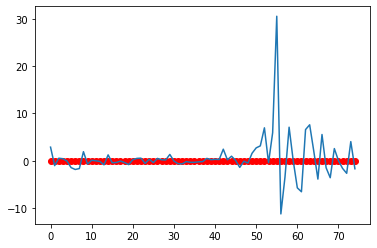

dict_keys(['loss', 'mse', 'mae', 'mape'])


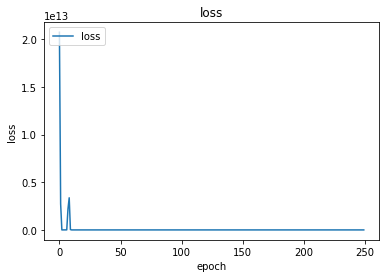

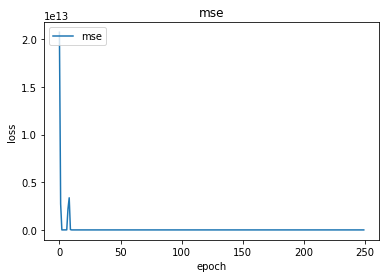

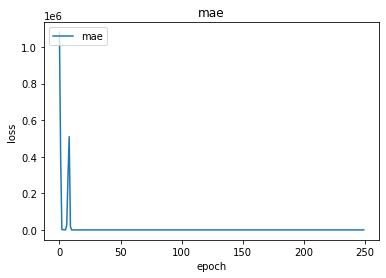

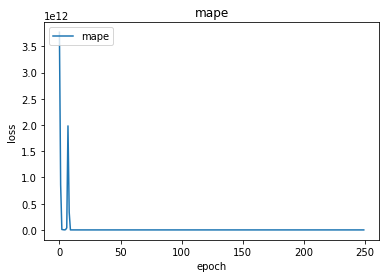

In [77]:
optimizer = optimizers.RMSprop(0.0099)
#create and fit the Regression network
def model_regr(dim_size,lrn_rate = 0.01, mntum = 0 ):
    #Intializing the RNN
    model = Sequential()
    #1st layer
    model.add(layers.Dense(dim_size*2, activation='relu', input_shape=(dim_size,)))
    model.add(layers.Dense(dim_size*4, activation='relu'))
    model.add(layers.Dense(dim_size*2, activation='relu'))
    #model.add(layers.Dense(dim_size*2, activation='relu'))
    #model.add(layers.Dense(dim_size, activation='relu'))
    #model.add(layers.Dense(dim_size/2, activation='relu'))
    #network.add(layers.Dense(32, activation='relu'))
    #network.add(layers.Dense(1))
    #model.add(Dropout(0.2))
    #2nd layer
    #model.add(layers.Dense(dim_size, activation='relu'))
    #network.add(layers.Dense(dim_size, activation='relu'))
    #network.add(layers.Dense(dim_size, activation='relu'))
    #network.add(layers.Dense(dim_size/4, activation='relu'))
    #network.add(layers.Dense(dim_size/8, activation='relu'))
    #model.add(Dropout(0.2))
    #Adding the output layer
    model.add(layers.Dense(1))
    #model.compile(loss = 'mse', optimizer='adam', metrics=['mse','mae','mape'])
    #model.compile(loss = 'mse', optimizer='RMSprop', metrics=['mse','mae','mape'])
    model.compile(loss = 'mse', optimizer='adam', metrics=['mse','mae','mape'])
    return model

X,y = np.array(df), np.array(target)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)
#x_train =     np.array(df[:200])
#y_train = np.array(target[:200])
#x_test =     np.array(df[201:])
#y_test = np.array(target[201:])

start_time = time.time()
print(x_train.shape[1])
regr = model_regr(x_train.shape[1],lrn_rate=0.01, mntum=0)
history = regr.fit(x_train, y_train, batch_size=1, verbose=0, epochs=250)
print(f"Run time internal GPU: {time.time()-start_time}")
result = regr.predict(x_test)
display_size = 40

fig,ax = plt.subplots()

ax.plot(range(len(y_test)),y_test )
ax.scatter(range(len(result)),result,color='red' )


    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

print(history.history.keys())

for x in history.history.keys():
    plt.plot(history.history[x],label=x)
#plt.plot(history.history['val_loss'])
    plt.title(x)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

In [55]:
x_test

array([[ 2.16000000e+00,  4.02784380e+07,  2.30000000e+00, ...,
         4.37628324e-04, -9.01863465e-05,  1.07580069e-03],
       [ 2.12000000e+00,  2.82342510e+07,  2.17000000e+00, ...,
        -1.07315820e-03, -2.04192491e-04,  2.74511841e-04],
       [ 2.01000000e+00,  2.98737960e+07,  2.20000000e+00, ...,
        -4.93266029e-03, -9.25836449e-04,  1.23302955e-03],
       ...,
       [ 5.67000000e+01,  8.03512190e+07,  5.79800000e+01, ...,
         1.87293924e-03,  2.50977118e-03, -2.85066912e-03],
       [ 5.40600000e+01,  7.75969270e+07,  5.57500000e+01, ...,
         4.47378720e-04,  2.40974159e-03, -1.12346002e-03],
       [ 5.81100000e+01,  9.93102400e+07,  5.51000000e+01, ...,
         3.27695556e-03, -5.18661411e-04,  5.52338303e-04]])

In [16]:
"""
#This is cool but likely a dead end

def recurse_search(needle,haystack):

    #print(f"recurse: {needle} {len(haystack)}")

    if len(haystack) < 10:
        #print("10 Stack")
        #print(haystack)
        return haystack

    half_dex = int(len(haystack) / 2)

    if needle >= haystack[half_dex]:
        return recurse_search(needle,haystack[half_dex:])
    else:
        return recurse_search(needle,haystack[:half_dex])

print("!")    
def get_bin_time(needle,haystack):
    
    small_stack = recurse_search(needle,haystack)
    for index in range(len(haystack)):
        
        
        if index+1 > len(haystack):
            #print(haystack[index])
            return haystack[index]

        if (needle > haystack[index]):
            if needle < haystack[index+1]: 
               # print(f"{index}:{len(haystack)} [{haystack[index]} > {needle} < {haystack[index+1]}]")

                return haystack[index]

    

#//*** Bin comments into times centered around pricing
bin_time = []
print("Binning Times")
start_time = time.time()
#raw_df['bin_time'] = raw_df['created_utc'].sort_values().apply(lambda x: get_bin_time(x,stock_times))


for x in comment_times:
    
    bin_time.append(get_bin_time(x,stock_times))
    if len(bin_time) > 100000:
        break
print(f"Binned {round(time.time()-start_time,2)}")
    
"""
print()

LTSM: https://www.datacamp.com/community/tutorials/lstm-python-stock-market


In [78]:
import time
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [72]:
X,y = np.array(df), np.array(target)


#//***Split the Time Series
x_train = X[:int(len(df)*.8)]
x_test = X[int(len(df)*.8):]

print(x_train.shape)
print(x_test.shape)

y_train = y[:int(len(df)*.8)]
y_test = y[int(len(df)*.8):]

#//*** Normalize the Data
scaler = MinMaxScaler()
x_train = x_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)


NameError: name 'df' is not defined

In [100]:
tsvd_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
0,0.991314,0.054104,-0.050060,0.006952,0.039406,0.004030,-0.006735,-0.010038,-0.008445,0.017895,0.004040,0.013706,-0.016065,-0.021605,0.016376,0.004742,0.001711,0.013801,-0.003452,-0.007304,0.013939,-0.005231,0.007236,0.008323,0.000365,-0.010642,0.013322,-0.012970,-0.023986,-0.000632,0.002265,0.007303,-0.002594,-0.003007,-0.014112,0.013775,-0.019857,0.002292,-0.004612,0.004530,0.006544,0.001145,0.006340,0.010892,-0.009996,0.000772,0.009080,-0.011549,0.020632,-0.006462,-0.010882,0.005955,-0.019560,-0.011278,0.009346,0.005073,0.010090,0.013276,0.005842,-0.019419,-0.004282,0.002087,-0.004569,-0.000094,-0.005557,0.006475,-0.006256,-0.001994,0.019709,-0.001258,0.006628,-0.011376,-0.003519,-0.012462,0.003763,-0.015781,0.008838,-0.013855,-0.015169,0.012739,-0.002220,0.006691,0.000393,0.000307,-0.006131,-0.007456,-0.017951,0.006585,-0.012647,0.010483,-0.001090,0.001295,-0.005603,-0.001271,0.003223,-0.004752,0.000076,0.015237,-0.003557,0.006189,0.001262,0.003251,-0.008788,0.000820,0.002250,-0.006161,0.000018,-0.004674,0.003812,0.001717,-0.000234,-0.001079,0.000105,0.000432,-0.003256,-0.000496,0.001778,-0.005425,-0.003181,-0.003328,0.001105,-0.005892,0.000981,-0.003266,0.003448,0.000008,-0.002131,-0.000463,0.002705,-0.004267,-0.000102,0.003420,0.001133,-0.002793,0.000371,-0.001723,0.001960,-0.003325,0.003592,0.001402,-0.001786,0.002058,0.001158,0.000046,0.003439,0.002281,0.002045,-0.000524,-0.000213,0.000332,-0.002014,0.003661,0.003569,-0.001686,-0.000796,-0.001977,-0.000976,0.000632,0.002395,0.000391,-0.002912,-0.000969,-0.000149,0.001835,0.000966,0.001103,-0.000757,0.000655,0.000898,0.000255,-0.002372,-0.000765,-0.000310,0.000063,-0.000431,0.002906,-0.000190,-0.000743,0.000025,0.002806,-0.001197,0.001500,0.002214,-0.000722,-0.002284,0.001566,-0.001014,0.001270,-0.000358,-0.000927,0.000337,0.000253,-0.001525,0.000663,0.000233,0.000758,-0.000011,0.000521,0.000741,0.000012,-0.000254,0.001048,0.000646,0.000528,-0.000663,-0.001152,0.000405,0.000130,-0.000798,-0.001446,-0.001120,-4.588894e-04,0.000206,-0.000059,-0.000096,0.000942,-0.000211,0.000668,0.000281,0.000130,0.000413,0.000274,0.000341,9.248884e-04,0.001088,-0.000653,0.000308,-0.000373,0.000083,-0.000242,0.000512,0.000202,-0.000245,0.000026,-0.001246,-0.000615,-0.000277,0.000102,0.000309,-0.000122,-0.000138,0.000670,0.000161,0.001714,-0.000012,-0.000061,-0.000016,-0.000220,0.000119,0.000196
1,0.993132,0.017348,-0.042556,-0.014265,0.023067,-0.007242,-0.004438,-0.016826,-0.012378,0.017858,0.009827,0.018274,-0.015075,-0.028342,-0.006502,-0.002989,-0.006286,0.003372,0.003140,-0.006669,0.000724,-0.003049,-0.000961,-0.000471,-0.007846,-0.004924,-0.002736,-0.002955,0.009727,0.008749,-0.006159,-0.002913,0.015947,0.008733,-0.002272,-0.001469,-0.005563,-0.015435,-0.003718,0.014144,0.012848,-0.005368,0.018591,0.007614,-0.013793,0.012401,-0.004460,-0.007088,0.010826,0.015677,0.014403,0.005797,0.003882,-0.008618,-0.000180,0.009963,0.017971,0.011133,0.032181,-0.007242,-0.006453,-0.006692,-0.012983,-0.004703,-0.029362,-0.013455,0.000287,-0.000221,0.005386,-0.008859,0.010558,0.026630,0.003499,0.000204,0.006438,0.018483,-0.005

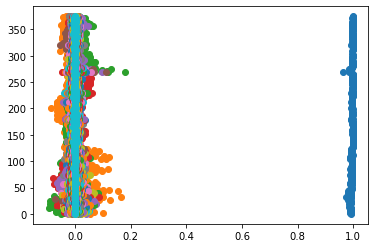

In [108]:
fig,ax = plt.subplots()

for col in tsvd_df.columns:

    ax.scatter(tsvd_df[col],tsvd_df.index,label=col )


    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

In [129]:
from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
        curr_center = centroids[pred_clusters[i]]
        curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
    return sse

dir(tfidf_matrix)
#kmeans = KMeans(n_clusters=2).fit(tfidf_matrix)
dir(kmeans)
kmeans.score(tfidf_matrix)
k_scores = []
for x in [5,10,15,20,25,50]:
    start_time=time.time()
    kmeans = KMeans(n_clusters=x).fit(tfidf_matrix)
    loop_score = kmeans.score(tfidf_matrix)
    print(f"{x} - {loop_score} - {time.time()-start_time}s")
    k_scores.append(loop_score)
print(k_scores)

5 - -2.724073194414555 - 16.213433265686035s
10 - -2.3000703136647034 - 32.40215015411377s
15 - -2.144877336345818 - 44.94786286354065s
20 - -2.0273404623857907 - 58.040358543395996s
25 - -1.9228962607929785 - 72.44540643692017s
50 - -1.5103614496527031 - 138.71485328674316s
[-2.724073194414555, -2.3000703136647034, -2.144877336345818, -2.0273404623857907, -1.9228962607929785, -1.5103614496527031]


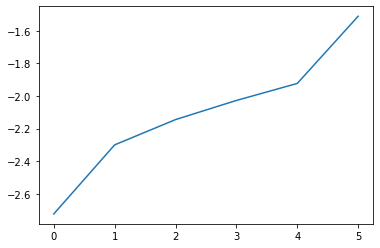

In [131]:
fig,ax = plt.subplots()

ax.plot(range(len(k_scores)),k_scores )


    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

Kmeans + Mean Shift: https://jamesxli.blogspot.com/2012/03/on-mean-shift-and-k-means-clustering.html


In [133]:
dir(kmeans)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algorithm',
 '_check_mkl_vcomp',
 '_check_n_features',
 '_check_params',
 '_check_test_data',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_init_centroids',
 '_more_tags',
 '_n_init',
 '_n_threads',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_tol',
 '_transform',
 '_validate_center_shape',
 '_validate_data',
 'algorithm',
 'cluster_centers_',
 'copy_x',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inertia_',
 'init',
 'labels_',
 'max_iter',
 'n_clusters',
 'n_features_in_',
 'n_init',
 'n_iter_',
 'n_jobs',
 'precompute_distances',
 'predict'

In [71]:
tt = pd.DataFrame()
tt['close'] = df['close']

for x in range(1,10):
    print(x)
    start_time=time.time()
    kmeans = KMeans(n_clusters=5).fit(tfidf_matrix)
    
    guess = kmeans.predict(tfidf_matrix)
    fig,ax = plt.subplots()
    
    tt[f"cluster_5_{x}"] = guess[:-1]

    ax.scatter(range(tfidf_matrix.shape[0]),guess,label=x )
    plt.suptitle(f"k=5, run={x}\nScore={kmeans.score(tfidf_matrix)}\nTime: {round(time.time()-start_time),2}s")

        #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

    
print(k_scores)

NameError: name 'df' is not defined

In [193]:
tt['target'] = tt['close']+target
abs(tt[100:].corr()[['target','close']]).sort_values('close',ascending=False)
print()

,target,close
close,0.979653,1.000000
target,1.000000,0.979653
cluster_5_1,0.529833,0.525088
cluster_5_6,0.529833,0.525088
cluster_5_5,0.527411,0.522139
cluster_5_8,0.527411,0.522139
cluster_5_7,0.514218,0.512127
cluster_5_4,0.464843,0.462781
cluster_5_2,0.388782,0.381735
cluster_5_9,0.285063,0.288653


In [183]:
tt.corr()['close']

close          1.000000
cluster_5_1   -0.498811
cluster_5_2   -0.156911
cluster_5_3    0.040917
cluster_5_4    0.269618
cluster_5_5   -0.515975
cluster_5_6   -0.501971
cluster_5_7    0.438842
cluster_5_8   -0.515975
cluster_5_9    0.201594
target         0.015713
Name: close, dtype: float64

In [176]:
tt.corr()['close']

close          1.000000
cluster_5_1    0.290603
cluster_5_2    0.040917
cluster_5_3   -0.515756
cluster_5_4    0.201093
cluster_5_5    0.179257
cluster_5_6    0.269618
cluster_5_7    0.282473
cluster_5_8   -0.458412
cluster_5_9    0.197263
Name: close, dtype: float64

In [174]:
tt.corr()['close']

close           1.000000
cluster_10_1    0.092208
cluster_10_2   -0.278062
cluster_10_3   -0.353748
cluster_10_4   -0.476055
cluster_10_5   -0.245328
cluster_10_6   -0.033006
cluster_10_7   -0.131553
cluster_10_8   -0.156385
cluster_10_9   -0.425056
Name: close, dtype: float64

In [170]:
tt.corr()['close']

close          1.000000
cluster_5_1    0.276060
cluster_5_2    0.441386
cluster_5_3   -0.290184
cluster_5_4    0.201594
cluster_5_5   -0.156911
cluster_5_6    0.004441
cluster_5_7    0.039409
cluster_5_8    0.439444
cluster_5_9   -0.103750
Name: close, dtype: float64

In [162]:
tt.corr()

,close,cluster_5,cluster_10,cluster_25,cluster_50,cluster_75,cluster_100,cluster_150
close,1.000000,0.414689,0.460465,-0.284076,-0.382085,-0.272740,0.151849,-0.203602
cluster_5,0.414689,1.000000,0.389358,-0.110443,-0.359771,-0.199820,-0.032285,-0.082539
cluster_10,0.460465,0.389358,1.000000,-0.041056,-0.292241,0.049413,0.115789,0.064449
cluster_25,-0.284076,-0.110443,-0.041056,1.000000,-0.034100,0.191063,-0.041367,0.210094
cluster_50,-0.382085,-0.359771,-0.292241,-0.034100,1.000000,0.202135,0.154907,0.098307
cluster_75,-0.272740,-0.199820,0.049413,0.191063,0.202135,1.000000,0.155501,0.090623
cluster_100,0.151849,-0.032285,0.115789,-0.041367,0.154907,0.155501,1.000000,-0.167869
cluster_150,-0.203602,-0.082539,0.064449,0.210094,0.098307,0.090623,-0.167869,1.000000


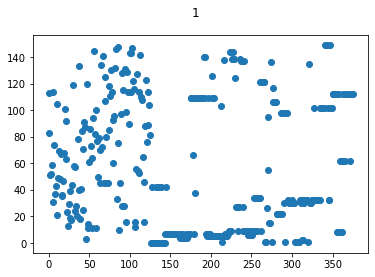

In [157]:
fig,ax = plt.subplots()


ax.scatter(range(tfidf_matrix.shape[0]),guess )

plt.suptitle("1")

#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

In [202]:
tfidf_matrix

<376x473472 sparse matrix of type '<class 'numpy.float64'>'
	with 5227966 stored elements in Compressed Sparse Row format>

In [201]:
X,y = np.array(df), np.array(target)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)

print(x_train)

[[ 7.46000000e+00  4.54593500e+06  7.30000000e+00 ... -2.20250648e-04
   1.18617077e-04  1.96344755e-04]
 [ 7.32000000e+00  2.21795900e+06  7.45000000e+00 ...  2.34846731e-04
   8.01382631e-05 -2.11982103e-04]
 [ 7.12000000e+00  2.90338100e+06  7.25000000e+00 ...  3.72057230e-04
  -1.57247021e-04 -1.21942272e-04]
 ...
 [ 1.05000000e+01  1.50415641e+08  9.38000000e+00 ...  3.04220137e-03
   8.29163416e-05 -4.86139277e-04]
 [ 9.85000000e+00  2.61918591e+08  1.10200000e+01 ...  2.51989914e-03
   2.89565925e-04  1.76833834e-04]
 [ 1.02800000e+01  8.39335890e+07  1.06500000e+01 ...  2.91512150e-03
  -7.37073507e-04 -1.17187418e-03]]


In [67]:
qamc = pd.read_csv("./stocks/amc_1min.csv.zip")
print(qamc.shape)
print(raw_df.shape)
print(stock_df.shape)

(292745, 6)
(4431599, 2)
(1818, 7)
